In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


# Selex (original Multibind)

In [36]:
n_rounds = 1
data = pd.read_csv('../data/countTable.0.CTCF_r3.tsv.gz', sep='\t', header=None)
data.columns = ['seq'] + [i for i in range(n_rounds+1)]
data.index = data['seq']
del data['seq']
data = data.sample(n=100)
# data.index = range(len(data))
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
# train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [37]:
data

,0,1
seq,,
GAGGGTAGTTCTAGTTATATGCAGAGGATT,0,1
TTCGCAAGTGGTCGGGGACTAGCCGCTGCT,1,0
GAGTTTGGTAGTTAACACGTTAGGTCATAT,0,1
TATTTGATATAGATGCGTAAAAATAAAGCG,0,1
ACGAGTCTGGTTCGTAACCGTGGTGGTGTG,1,0
...,...,...
AGCATCGGACTCTTCTGCCGTAACAACCTA,0,2
CGGAGTTTGCGGGGCTCAGTGCGAATCTAA,1,0
GCAGTCAGTCCTACTCGCCGTAGACCCAGA,1,0


In [38]:
model = mb.models.Multibind(kernels=[0, 14, 12], datatype="selex", n_rounds=1, n_batches=1).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.PoissonLoss()

In [39]:
mb.tl.train_network(model, train, device, optimiser, criterion, reconstruction_crit=None, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.PoissonLoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 2.032062 , best epoch: 9 secs per epoch: 0.028 s
Epoch: 21, Loss: 1.984900 , best epoch: 19 secs per epoch: 0.027 s
Epoch: 31, Loss: 1.937933 , best epoch: 29 secs per epoch: 0.026 s
Epoch: 41, Loss: 1.891197 , best epoch: 39 secs per epoch: 0.027 s
Epoch: 51, Loss: 1.844726 , best epoch: 49 secs per epoch: 0.027 s
Epoch: 61, Loss: 1.798560 , best epoch: 59 secs per epoch: 0.026 s
Epoch: 71, Loss: 1.752741 , best epoch: 69 secs per epoch: 0.026 s
Epoch: 81, Loss: 1.707317 , best epoch: 79 secs per epoch: 0.026 s
Epoch: 91, Loss: 1.662341 , best epoch: 89 secs per epoch: 0.025 s
Epoch: 101, Loss: 1.617877 , best epoch: 99 secs per epoch: 0.025 s
Epoch: 111, Loss: 1.573992 , best epoch: 109 secs per epoch: 0.026 s
Epoch: 121, Loss: 1.530763 , best epoch: 119 secs per epoch: 0.027 s
Epoch: 131, Loss: 1.4

# Pbm with Protein Sequences

In [40]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [41]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

# df = df.head(1000)
df = df.reindex(df.var(axis=1).sort_values()[-100:].index)

df

,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
seq,,,,,,,,,,,,,,,,,,,,,
CGCAGCCGCAGCTGGCGCCCCGGCGTCATAGGTCCCGTCTGTGTTCCGTTGTCCGTGCTG,-0.659682,-0.339073,-0.133640,-1.274016,-2.338438,-0.580987,-0.664403,-1.030671,-0.586772,-0.492374,...,-0.916333,-1.844645,-0.517965,-0.258997,-0.256025,-2.333840,-0.425937,-0.704508,-0.100726,-0.113527
GCCCCCCAGGTCAGACGAGTTGAACTTCAACCCTCCGTCTGTGTTCCGTTGTCCGTGCTG,-0.574053,-0.363282,-0.316799,-0.767258,-0.705346,-0.377647,-0.538784,-1.135303,-0.306191,-0.625336,...,-0.377701,-0.231998,0.068657,-0.061296,0.052286,-0.670127,-0.343824,-0.548323,-0.832650,-0.584504
GATAACCCTTAATTGGTCCTTCGCGATAGAAGGTCCGTCTGTGTTCCGTTGTCCGTGCTG,2.703159,3.578457,6.349597,2.675210,2.475441,3.133558,2.611887,2.589847,3.011796,4.810945,...,2.064428,0.584326,0.001060,0.046085,0.852027,0.996424,3.488596,2.619404,3.006790,3.014480
GGTAGAGGTGGAACCGCGGTACTAATTAGATCAGGCGTCTGTGTTCCGTTGTCCGTGCTG,2.714021,2.838746,6.501419,0.889622,1.492980,0.941923,1.278587,1.700570,1.883797,4.067142,...,0.530237,0.147995,-0.161132,-0.176242,-0.952434,0.843187,4.228793,2.126193,2.044937,2.820259
TGTGTAATTAATAAGTCCCACCATTCCACTTAGGTTGTCTGTGTTCCGTTGTCCGTGCTG,3.283341,3.833442,6.952337,2.223529,2.219933,2.355134,2.030986,2.430479,2.813665,4.681918,...,1.453141,0.669079,-0.152009,-0.042625,1.240002,0.879946,5.029708,2.767530,3.509563,3.446345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCGTGGCGTTCGCGACCATCGCAAACACGCTTTAGTCTGTGTTCCGTTGTCCGTGCTG,-0.142679,-0.291169,-0.218436,-0.771649,-0.031972,-0.237209,-0.187451,-0.494980,-0.355316,-0.088961,...,-0.790043,-0.125247,-0.058295,-0.079560,-0.053942,0.105131,-0.196084,-0.202346,0.113713,0.414194
TCGTACCAGCATTTATCAGGTAGCGGAGTGCCAAATGTCTGTGTTCCGTTGTCCGTGCTG,-0.340468,-0.189254,0.206141,0.418631,1.773758,1.444734,0.402644,0.688725,0.453532,0.355970,...,0.188191,-0.068568,0.237085,-0.025857,-0.304529,0.398035,0.306394,-0.003307,-0.533505,-0.258099
CGTTAATCGTGCAGTAGTTACGGTGCATTCAACATCGTCTGTGTTCCGTTGTCCGTGCTG,0.306300,0.225155,1.534268,0.188276,1.905877,1.456514,1.560607,1.662665,2.553022,1.218580,...,2.835337,0.808221,-0.211474,-37.334557,-0.893831,0.313406,0.731129,1.070064,0.936499,0.363930


In [42]:
dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [43]:
# Set up the model
bm_generator = mb.models.BMPrediction(num_classes=1, input_size=21, hidden_size=2, num_layers=1, seq_length=88)
model = mb.models.Multibind(datatype='pbm', bm_generator=bm_generator)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = None  # torch.nn.CrossEntropyLoss()

In [45]:
model = model.cuda() if 'cuda' in str(device) else model

In [46]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 4.314022 , best epoch: 0 secs per epoch: 3.693 s
Epoch:  3, Loss: 4.250663 , best epoch: 1 secs per epoch: 2.622 s
Epoch:  4, Loss: 4.176695 , best epoch: 2 secs per epoch: 2.231 s
Epoch:  5, Loss: 4.114237 , best epoch: 3 secs per epoch: 2.036 s
Epoch:  6, Loss: 4.047101 , best epoch: 4 secs per epoch: 1.955 s
Epoch:  7, Loss: 3.986602 , best epoch: 5 secs per epoch: 1.905 s
Epoch:  8, Loss: 3.917452 , best epoch: 6 secs per epoch: 1.873 s
Epoch:  9, Loss: 3.723020 , best epoch: 7 secs per epoch: 1.855 s
Epoch: 10, Loss: 3.641790 , best epoch: 8 secs per epoch: 1.836 s
Epoch: 11, Loss: 3.623405 , best epoch: 9 secs per epoch: 1.823 s
Epoch: 12, Loss: 3.665911 , best epoch: 10 secs per epoch: 1.812 s
Epoch: 13, Loss: 3.618772 , best epoch: 10 secs per epoch: 1.793 s
Epoch: 14, Loss: 3.635528 , best epoch: 1

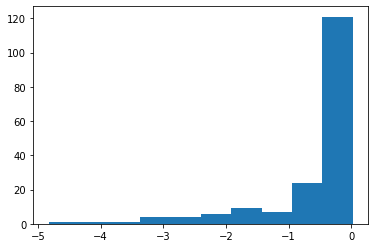

array([-1.67176100e-01, -4.63600101e-01, -1.02685019e+00,  1.53128919e-02,
       -1.22362676e-02, -6.52704604e-02,  9.09689738e-03,  4.24549725e-03,
       -2.64610172e-01, -6.56365213e-01, -1.09677322e-01,  7.33882876e-03,
        2.53303244e-02, -3.65936570e+00, -2.18846909e-01, -3.14008986e-01,
       -7.98203917e-01, -1.62907087e+00, -8.88847572e-02, -1.31287635e-01,
       -2.68721760e-01, -4.13916162e-01, -9.00804499e-02,  1.56262922e-02,
       -6.65777994e-01, -2.34087273e+00, -1.18999052e+00,  1.84695169e-02,
       -3.81403234e-01, -3.50593682e-02, -5.89263358e-02, -5.34719149e-01,
       -5.29303620e-01,  2.63883806e-03, -1.37970454e-02, -2.55908772e-02,
       -1.32123745e-01,  2.00889445e-04, -3.37282735e+00, -2.14492470e-01,
       -1.50391982e-01, -1.95952132e+00,  1.56319263e-02,  1.81966962e-02,
       -3.37523607e-02, -7.64864950e-02, -1.83114884e-01, -3.98475085e-01,
       -2.14293908e-01, -1.29934753e-01, -4.59986979e-02, -4.43906929e-01,
       -5.18316065e-02, -

In [47]:
mb.pl.R2_per_protein(model, train, device)

# PBM: Leaving out one column (one TF)

In [48]:
train_df = df[range(1, 178)].copy()
test_df = df[[0]].copy()

train_dataset = mb.datasets.ResiduePBMDataset(train_df, x[1:178])
train = tdata.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataset = mb.datasets.ResiduePBMDataset(test_df, x[0:1])
test = tdata.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [49]:
# Set up the model
bm_generator = mb.models.BMPrediction(num_classes=1, input_size=21, hidden_size=2, num_layers=1, seq_length=88)
model = mb.models.Multibind(datatype='pbm', bm_generator=bm_generator)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = None  # torch.nn.CrossEntropyLoss()

In [53]:
model = model.cuda() if 'cuda' in str(device) else model

In [55]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 3.746204 , best epoch: 0 secs per epoch: 3.094 s
Epoch:  3, Loss: 3.702214 , best epoch: 1 secs per epoch: 2.295 s
Epoch:  4, Loss: 3.633651 , best epoch: 2 secs per epoch: 2.050 s
Epoch:  5, Loss: 3.634558 , best epoch: 3 secs per epoch: 1.943 s
Epoch:  6, Loss: 3.624867 , best epoch: 3 secs per epoch: 1.888 s
Epoch:  7, Loss: 3.654384 , best epoch: 5 secs per epoch: 1.908 s
Epoch:  8, Loss: 3.596529 , best epoch: 5 secs per epoch: 1.872 s
Epoch:  9, Loss: 3.538421 , best epoch: 7 secs per epoch: 1.837 s
Epoch: 10, Loss: 3.475042 , best epoch: 8 secs per epoch: 1.830 s
Epoch: 11, Loss: 3.431310 , best epoch: 9 secs per epoch: 1.827 s
Epoch: 12, Loss: 3.386775 , best epoch: 10 secs per epoch: 1.816 s
Epoch: 13, Loss: 3.335490 , best epoch: 11 secs per epoch: 1.809 s
Epoch: 14, Loss: 3.292606 , best epoch: 1

In [56]:
mb.pl.R2_per_protein(model, test, device, show_plot=False)

array([0.43285976])